In [1]:
import os
import shutil

import pandas as pd
import numpy as np
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, TQDMProgressBar
import albumentations as A
import plotly.io as pio

from autoencoderlib import FCAutoEncoder, CNNAutoEncoder
from autoencoderlib import calc_conv2d_output_size, calc_transpose_conv2d_output_size
from autoencoderlib import plot_latent_tsne, print_autoencoder_result
from mnistlib import MNISTDataModule
from parrotslib import ParrotDataModule
from imagenetlib import ImagenetteDataModule, BaseImageTransform

In [2]:
# Вывод графиков plotly в формате jpeg, требуется для сохранения данных в ноутбуке
# Если нужна интерактивность графиков, то требуется заккоментировать ячейку.
# В этом случае графики plotly будут удалены после перезапуска ноутбука.

!pip install -U kaleido
pio.renderers.default = 'jpeg'

# Домашняя работа № 6

В домашней работе требуется провести исследовательскую работу с обучением разных типов автоэнкодеров.


В базовом варианте домашней работы требуется обучить многослойный автоэнкодер на основе полносвязной сети на датасете MNIST в 2 вариациях:
- стандартный автоэнкодер;
- шумоподавляющий автоэнкодер.

После обучения каждой модели требуется отобразить с помощью t-SNE выход латентного слоя.


## 1 Обучение многослойного автоэнкодера на базе полносвязной нейронной сети

### 1.1 Описание вспомогательных классов

Для выполнения этой части домашней работы были реализованы классы **FCModel** (модель полносвязной сети) и **FCAutoEncoder** (автоэнкодер на базе полносвязной сети).

#### 1.1.1 Класс FCModel

Класс позволяет создать полносвязную модель, в котором размер слоев и количество нейронов в каждом слое являются гиперпараметром.

Пример инициализации класса:

> model = FCModel(input_size=768, model_dims=[1024, 512, 256, 128], dropout=False, last_activation='sigmoid')

С помощью гиперпараметра model_dims можно задать структуру полносвязной сети. Длина списка - количество полносвязных слоев. Значения списка - количество нейронов в каждом полносвязном слое. Более подробную документацию можно посмотреть в файле autoencoderlib.py. Таким образом с помощью данного класса можно реализовать как энкодер, так и декодер автоэнкодера.

#### 1.1.2 Класс FCAutoEncoder

Класс реализует модель автоэнкодера с помощью класса FCModel. Класс наследуется от pl.LightningModule.

Пример инициализации класса:

> model = FCAutoEncoder(image_size=48, encoder_dims=[1024, 512, 256], decoder_dims=[256, 512, 1024, 48\*48\*3], latent_size=128, channel_count=3, loss_fn='mse', last_activation='sigmoid', noised=True, learning_rate=0.001, l2_regularization=0.01, adam_betas=(0.99, 0.999), plot_epoch_loss=True, seed=2022)

В гиперпараметрах encoder_dims и decoder_dims требуется указать структуру слоев энкодера и декодера. В данном примере приведена инициализация симметричного автоэнкодера. Важно соблюдать условие: выход декодера должен совпадать с размером изображения. Так как в примере берем трехканальное изображение размером 48*48, то выход декодера должен иметь размер 48 x 48 x 3.

В last_activation указываем функцию активации, которая будет применена к выходу автоэнкодера. Область значений функции должен совпадать с областью значений входного изображения с учетом всех аугментаций.

Если noised=False, то модель будет считать функцию ошибок на изображении с базовым преобразованием. Иначе для прямого прохода будет использоваться изображение с аугментацией для обучения, а для подсчета функции ошибок будет использоваться изображении с базовым преобразованием.

**ВАЖНО**: для корректной работы модели с установленным флагом noised=True требуется корректная настройка модуля изображений модели. Сама модель непосредственно никаких преобразований изображений не делает. В случае обучения зашумленного автокодировщика модель будет брать для прямого прохода batch['img_transform'], а для подсчета функции ошибок batch['img_source']. А для стандартного обучения будет брать в обоих случаях batch['img_source']. Аугментация для загрузчиков изображений будет описан в следующем разделе.

Более подробную документацию о классе можно посмотреть в файле autoencoderlib.py

#### 1.1.3 Класс MNISTDataModule

Модуль изображений для датасета MNIST.

> datamodule = MNISTDataModule(dataset_params={base_transforms=BaseImageTransform(), train_transforms=BaseImageTransform(), val_transforms=BaseImageTransform()}, train_loader_params={'batch_size': 16, 'shuffle': True, 'drop_last'=True}, val_loader_params={'batch_size': 16, 'shuffle': True, 'drop_last'=True})

Все используемые модули изображений инициализируются по похожему принципу.

В параметры трансформации передаются экземпляры класса BaseImageTransform. Он позволяет создавать цепочки обработки изображений с помощью фреймворка Albumentations. Описание класса можно найти в файле mnistlib.py. 

В base_transforms требуется передать минимальные необходимые преобразования изображений для обучения модели. Например, изменение размера, стандартизация и преобразование в тензор. Здесь не должны быть функции аугментации.

В случае, если мы обучаем нешумный автоэнкодер, то как для обучения, так и для подсчета ошибки будут использоваться преобразования из base_transforms. В этом случае train_transforms и val_transforms можно инициализировать в виде None.

Если мы включаем обучение шумного автоэнкодера с помощью флага noised=True при инициализации модели, тогда для прямого прохода при обучении будут браться преобразования из train_transforms, а для подсчета ошибки преобразования из base_transforms. При этом валидация будет использовать преобразования из base_transforms. Таким образом, при включении noised=True в train_transforms можно использовать разные типы аугментаций для обучения шумного автоэнкодера.

Словари параметров train_loader_params и val_loader_params используются для инициализации класса torch.utils.data.DataLoader и поддерживают все параметры указанного класса.

Более подробную документацию о классе можно посмотреть в файле mnistlib.py

#### 1.1.4 Класс ImagenetteDataModule

Модуль изображений для датасета Imagenette.

Работает с датасетами imagenette из https://github.com/fastai/imagenette
Класс тестировался на датасете https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz

Класс инициализируется аналогично MNISTDataLoader, только имеет один дополнительный параметр: imagenette_path.
С помощью него требуется указать путь к папке с датасетом imagenette.

Более подробную документацию о классе можно посмотреть в файле imagenetlib.py


#### 1.1.5 Класс ParrotDataModule

Модуль изображений для датасета Cockatiel VS Cockatoo из домашнего задания №3. Класс был адаптирован под текущую задачу.

Класс удобно инициализировать через метод класса create_datamodule.

> datamodule = ParrotDataModule.create_datamodule(parrot_xlsx, photo_dir, train_loader_params, dataset_params, seed)

Параметры инициализации аналогичны MNISTDataLoader, только имеет два дополнительных параметра: parrot_xlsx и photo_dir.
В parrot_xlsx указываем путь к файлу разметки датасета в формате xlsx. А в photo_dir указываем путь к папке с изображениями.

Более подробную документацию о классе можно посмотреть в файле parrotslib.py

Датасет находится в архиве https://github.com/inject0r1945/otus_cv/blob/main/02_augmentation/parrots_images.zip

### 1.2 Обучение модели на данных MNIST
#### 1.2.1 Стандартный автоэнкодер для MNIST

Обучим модель с размером латентного слоя 2. А также добавим по одному полносвязному слою в энкодер и декодер размером 128 нейронов. В качестве функции активации последнего слоя автоэнкодера выберем сигмоиду, так как после стандартизации изображений у нас будут значения от 0 до 1.

In [3]:
SEED = 24

IMAGE_SIZE = 28
IMAGE_CHANNEL_COUNT = 1

base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=1, mean=0)
train_transforms = None

print("Базовые трансформации изображений датасета MNIST:\n")
print(base_transforms)

Базовые трансформации изображений датасета MNIST:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=0, std=1, max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [4]:
config = {'seed': SEED,
          'model': {
              'encoder_dims': [128],
              'decoder_dims': [128, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT],
              'latent_size': 2,
              'loss_fn': 'mse',
              'image_size': IMAGE_SIZE,
              'channel_count': IMAGE_CHANNEL_COUNT,
              'noised': False,
              'last_activation': 'sigmoid',
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'seed': SEED,
          },
          'datamodule': {
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 16,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              },
              'dataset_params': {
                  'base_transforms': base_transforms,
                  'train_transforms': train_transforms,
              },
          },
         'trainer': {
              'max_epochs': 5,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'resume_from_checkpoint': None,
          },
}

In [5]:
mnist_datamodule = MNISTDataModule(**config['datamodule'])
mnist_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(mnist_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=2, bias=True)
      (3): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


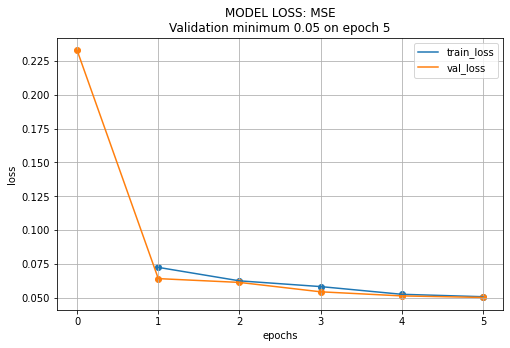

In [6]:
# Обучаем автоэнкодер
trainer.fit(mnist_fcautoencoder_model, mnist_datamodule)

In [7]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
mnist_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

ПО графику обучения мы можем увидеть, что модель практически на первой эпохе пришла к очень низкому значению функции ошибки. Значит ли это, что модель очень хорошо обучилась с латентным слоем размером в 2 нейрона? Дальше мы выясним это.

Для визуализации результатов обучения автоэнкодера воспользуемся подготовленной для этой задачи функцией print_autoencoder_result.

Функция выводит 8 результатов с 4 блоками:
- Src (исходное изображение)
- Rec Src (восстановление исходное изображение с помощью автоэнкодера)
- Aug (аугментированное изображение)
- Rec Src (восстановление аугментированное изображение с помощью автоэнкодера)

Так как мы обучали стандартный автоэнкодер, то исходное и аугментированное изображения будут совпадать.

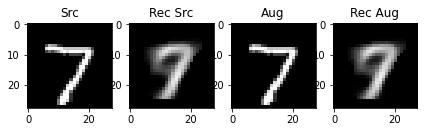

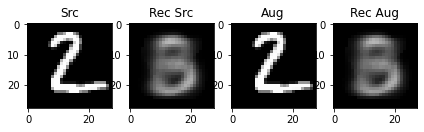

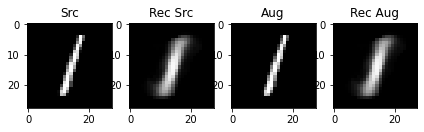

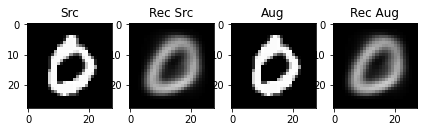

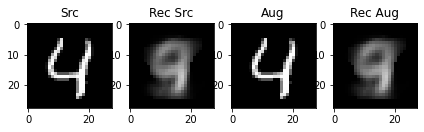

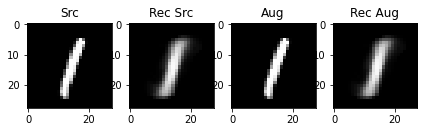

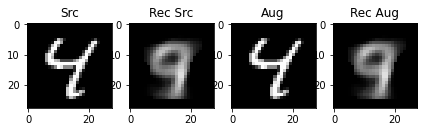

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [8]:
print_autoencoder_result(mnist_fcautoencoder_model, mnist_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, std=[1], mean=[0])

Из резульатов видно, что латентного слоя размером 2 не хватает для приемлемого восстановления изображения декодером. Модель просто начинает путать одни цифры с другими.

Построим t-SNE для латентного слоя:

New Shape of X:  (10000, 2)
Kullback-Leibler divergence after optimization:  0.7401552796363831
No. of iterations:  2999


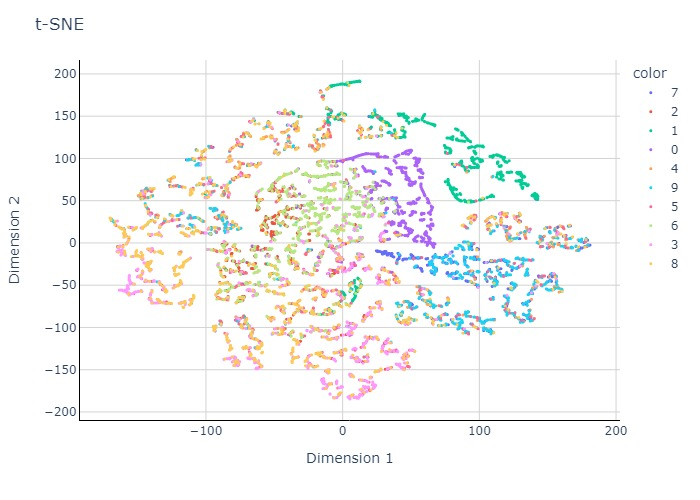

In [9]:
plot_latent_tsne(model=mnist_fcautoencoder_model, datamodule=mnist_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Из графика t-SNE видно, что четкой группировки у классов нет, классы перемешаны друг с другом.

Почему у нас получилась очень маленькая ошибка RMSE при обучении? Это можно объяснить тем, что изображения MNIST процентов 80% состоят из черного фона. Поэтому если цифра будет не совсем точно восстановлена, то ошибка RMSE все равно будет достаточно низкой.

Теперь увеличим латентный слой до 32 и заново обучим модель

In [10]:
config['model']['latent_size'] = 32

mnist_datamodule = MNISTDataModule(**config['datamodule'])
mnist_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(mnist_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=784, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=32, bias=True)
      (3): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


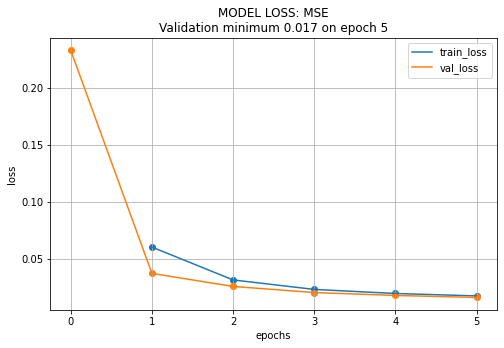

In [11]:
# Обучаем автоэнкодер
trainer.fit(mnist_fcautoencoder_model, mnist_datamodule)

In [12]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
mnist_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Обратим внимание, что ошибка при обучении уменьшилась почти в 3 раза по сравнению с предыдущей моделью (0.017 против 0.05).

Проверим результаты на валидационной части датасета:

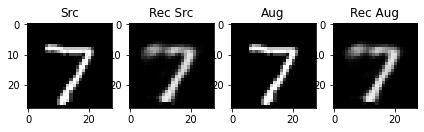

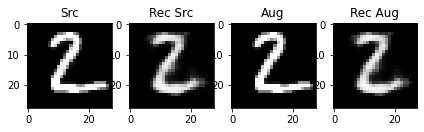

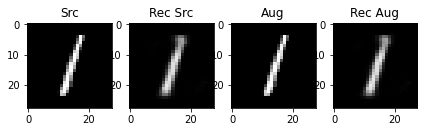

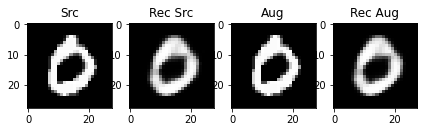

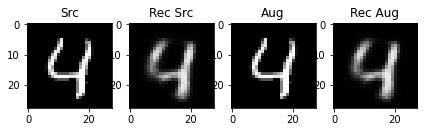

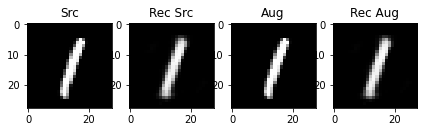

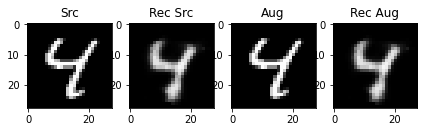

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [13]:
print_autoencoder_result(mnist_fcautoencoder_model, mnist_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, std=[1], mean=[0])

Следом за уменьшением ошибки RMSE почти в три раза, качество восстановления изображения также значительно выросло.

Построим график t-SNE для латентного слоя:

New Shape of X:  (10000, 2)
Kullback-Leibler divergence after optimization:  1.6665018796920776
No. of iterations:  2999


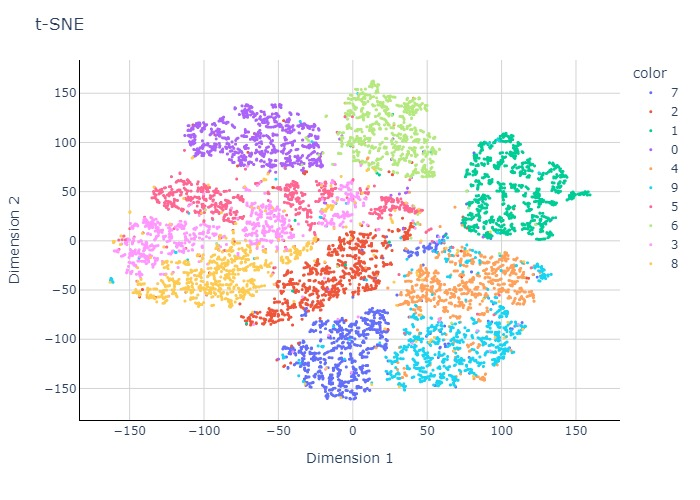

In [14]:
plot_latent_tsne(model=mnist_fcautoencoder_model, datamodule=mnist_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Из графика t-SNE видно, что теперь классы цифр группируются достаточно неплохо. На графике выделяются пятерка, тройка и восьмерка, которые не имеют единой группы и пересекаются друг с другом. Это значит, что не во всех случаях мы можем отличить эти цифры друг от друга.

Теперь увеличим латентный слой до 128, полносвязные слои энкодера и декодера с 128 до 256. И обучим модель заново.

In [15]:
config['model']['latent_size'] = 128
config['model']['encoder_dims'] = [256]
config['model']['decoder_dims'] = [256, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT]

mnist_datamodule = MNISTDataModule(**config['datamodule'])
mnist_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(mnist_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


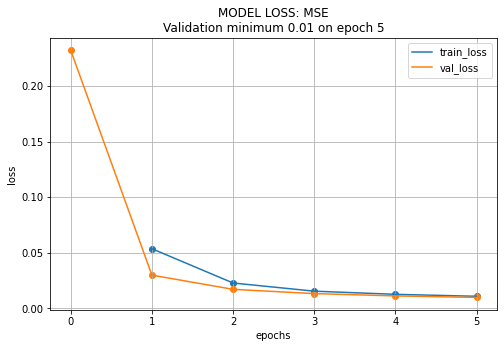

In [16]:
# Обучаем автоэнкодер
trainer.fit(mnist_fcautoencoder_model, mnist_datamodule)

In [17]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
mnist_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Обратим внимание, что ошибка уменьшилась почти в 2 раза по сравнению с предыдущей моделью (0.01 против 0.017) и в 5 раз по сравнению с первой (0.01 против 0.05).

Проверим результаты на валидационной части датасета:

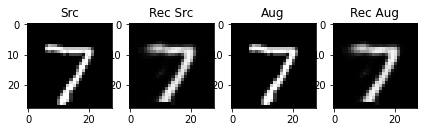

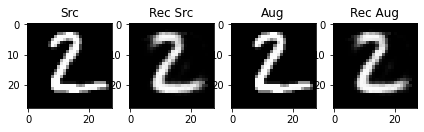

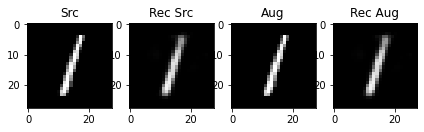

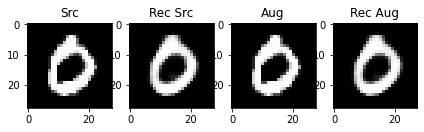

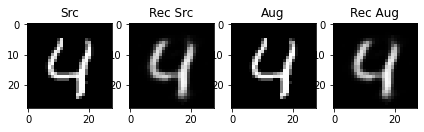

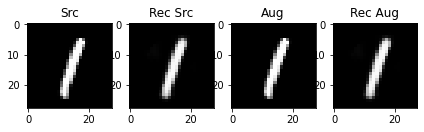

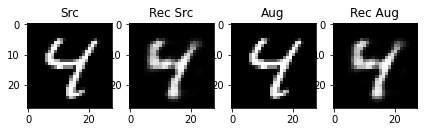

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [18]:
print_autoencoder_result(mnist_fcautoencoder_model, mnist_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, std=[1], mean=[0])

Качество восстановления улучшилось, восстановленные числа стали четче.

Посмотрим на график t-SNE:

New Shape of X:  (10000, 2)
Kullback-Leibler divergence after optimization:  1.7071244716644287
No. of iterations:  2999


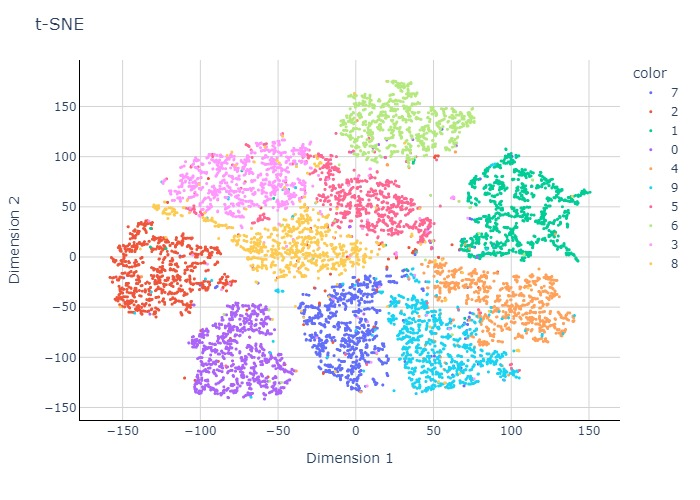

In [19]:
plot_latent_tsne(model=mnist_fcautoencoder_model, datamodule=mnist_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Как видно по графику t-SNE, теперь все классы имеют достаточно достаточно четкое разделение между собой, качество выделения признаков значительно улучшилось. Только в некоторых случаях мы можем перпутать восьмерку с тройкой и четверку с девяткой.

#### 1.2.2 Шумный автоэнкодер для MNIST

Добавим преобразование CoarseDropout для трансформации изображений на обучении. Будем закрывать до 50% изображения черным кубиком. В конфигурации модели активируем режим Noised.

In [20]:
train_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=1, mean=0) 

transforms_to_add = A.Compose([
    A.CoarseDropout (p=0.7, max_holes=1, min_width=int(IMAGE_SIZE*0.25), min_height=int(IMAGE_SIZE*0.25), 
                     max_width=int(IMAGE_SIZE*0.5), max_height=int(IMAGE_SIZE*0.5)),
])

for idx, new_transform in enumerate(transforms_to_add):
    train_transforms.add_transform(new_transform, idx+1)
    
config['model']['noised'] = True
config['datamodule']['dataset_params']['train_transforms'] = train_transforms
    
train_transforms

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  CoarseDropout(always_apply=False, p=0.7, max_holes=1, max_height=14, max_width=14, min_holes=1, min_height=7, min_width=7, fill_value=0, mask_fill_value=None),
  Normalize(always_apply=False, p=1.0, mean=0, std=1, max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

In [21]:
mnist_datamodule = MNISTDataModule(**config['datamodule'])
mnist_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100),
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(mnist_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=784, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=128, bias=True)
      (3): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): Linear(in_features=256, out_features=784, bias=True)
      (3): Sigmoid()
    )
  )
)


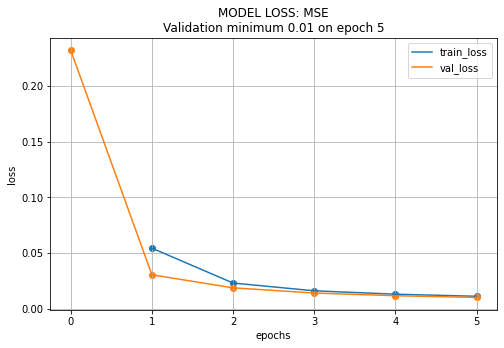

In [22]:
# Обучаем автоэнкодер
trainer.fit(mnist_fcautoencoder_model, mnist_datamodule)

In [23]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
mnist_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Обратим внимание, что мы сохранили на том же уровне размер ошибки при обучении (0.01). 

Аугментация применяется только на обучающем датасете, поэтому для проверки аугментации покажем результаты в режиме обучения:

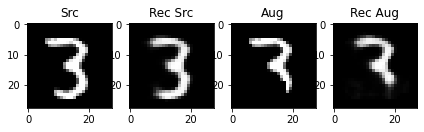

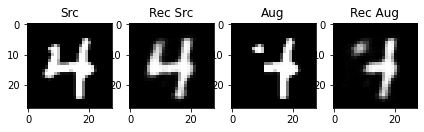

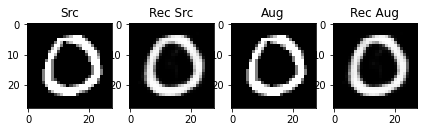

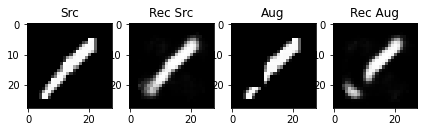

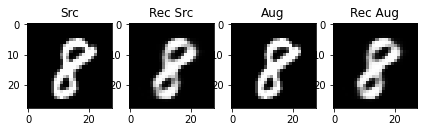

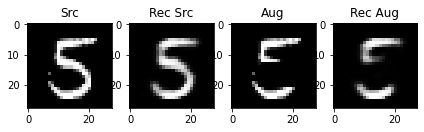

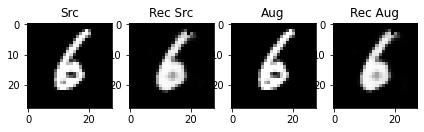

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [24]:
print_autoencoder_result(mnist_fcautoencoder_model, mnist_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='train', denormalize=True, std=[1], mean=[0])

Можно отметить, что модель не пытается восстановить отсутствующие части изображений, если подать на вход аугментирвоанные данные. Теперь проверим результат на валидации:

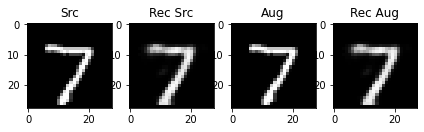

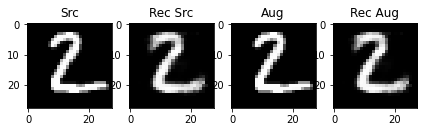

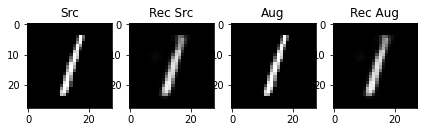

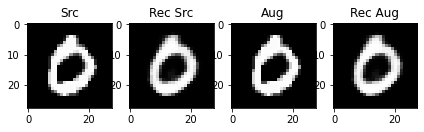

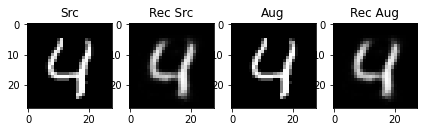

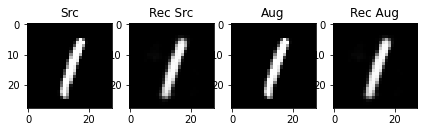

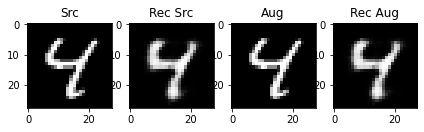

In [25]:
print_autoencoder_result(mnist_fcautoencoder_model, mnist_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, std=[1], mean=[0])

New Shape of X:  (10000, 2)
Kullback-Leibler divergence after optimization:  1.7046620845794678
No. of iterations:  2999


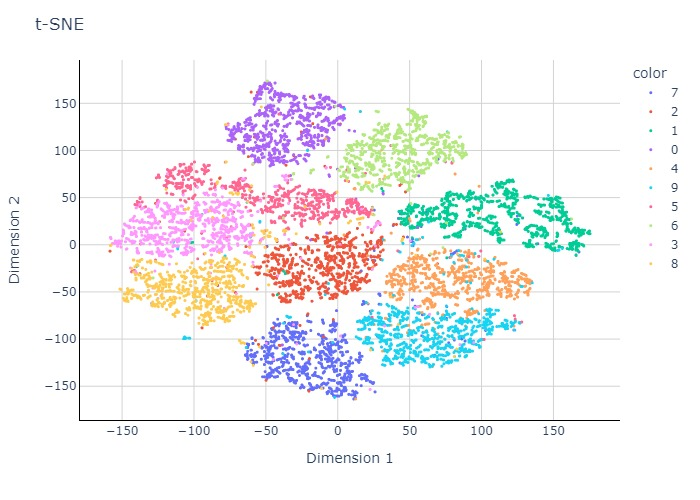

In [26]:
plot_latent_tsne(model=mnist_fcautoencoder_model, datamodule=mnist_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Несмотря на то, что мы сохранили уровень ошибки RMSE при обучении, после добавления Cutout качество выделения признаков немного ухудшилось: пятерка, шестерка и восьмерка хоть и относительно разделены, но сливаются в одно облако.

### 1.3 Обучение полносвязного автоэнкодера на  данных ParrotsDataset
#### 1.3.1 Стандартный автоэнкодер для ParrotsDataset

Обучим стандартный автоэнкодер на датасете Cockatiel VS Cockatoo. Датасет состоит из 100 изображений. Обучать модель будем точно так же на изображениях размером 28x28. Для стандартизации возьмем средние значения и СКО для ImageNet. Раньше на выходе модели применяли сигмоиду, в этом примере уберем активацию из последнего слоя автоэнкодера.

Так как данные изображения сложнее изображений из MNIST, в этом эксперименте у энкодера и декодера будут уже по 2 полносвязных слоя: на 2048 и 1024 нейронов.

In [27]:
SEED = 24

IMAGE_SIZE = 28
IMAGE_CHANNEL_COUNT = 3

STD_NORMALIZE = [0.229, 0.224, 0.225]
MEAN_NORMALIZE = [0.485, 0.456, 0.406]

base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = None

print("Базовые трансформации изображений датасета ParrotDataset:\n")
print(base_transforms)

Базовые трансформации изображений датасета ParrotDataset:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [28]:
config = {'seed': SEED,
          'model': {
              'encoder_dims': [2048, 1024],
              'decoder_dims': [1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT],
              'latent_size': 512,
              'loss_fn': 'mse',
              'image_size': IMAGE_SIZE,
              'channel_count': IMAGE_CHANNEL_COUNT,
              'noised': False,
              'last_activation': None,
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'seed': SEED,
          },
          'datamodule': {
              'parrot_xlsx': 'dataset.xlsx',
              'photo_dir': 'parrots_images',
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 16,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              },
              'dataset_params': {
                  'base_transforms': base_transforms,
                  'train_transforms': train_transforms,
              },
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'resume_from_checkpoint': None,
          },
}

Здесь мы целенаправленно мониторим ошибку на обучении, так как заведомо известно о большом переобучении модели и низком ее качестве на валидации. Цель - показать корректную работу автоэнкодера на части для обучения. По результату обучения на 100 эпохах откатим модель к лучшему результату ошибки на обучающей части.

In [29]:
parrot_datamodule = ParrotDataModule.create_datamodule(**config['datamodule'])
parrot_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='train_loss', mode='min'),
        TQDMProgressBar(refresh_rate=10), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(parrot_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=2352, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2352, bias=True)
    )
  )
)


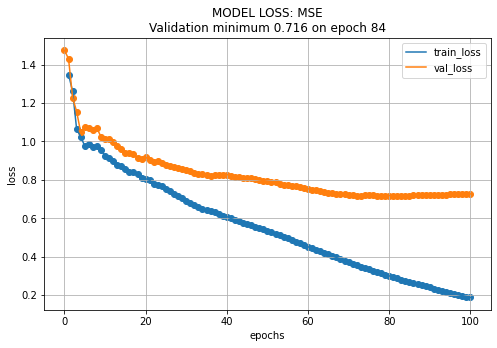

In [30]:
# Обучаем автоэнкодер
trainer.fit(parrot_fcautoencoder_model, parrot_datamodule)

In [31]:
# Откатим модель к чекпоинту с лучшим результатом на обучении
checkpoint = callbacks[0]
parrot_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Как видно из графика обучения модели, автоэнкодер сильно переобучается. И более менее приемлемые результаты будут у нас только на обучающей части датасета. Такое поведение можно объяснить малым количеством изображений в датасете. Для улучшения качества его необходимо значительно расширить. На текущий момент в нем всего 100 изображений.

Посмотрим результат на обучающем датасете:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


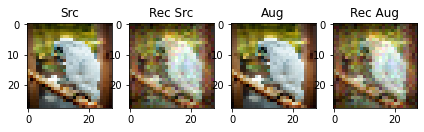

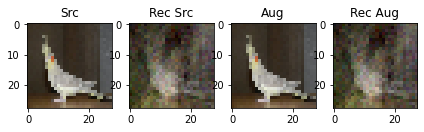

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


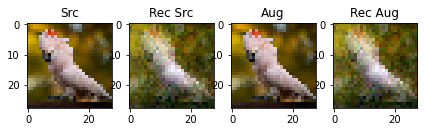

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


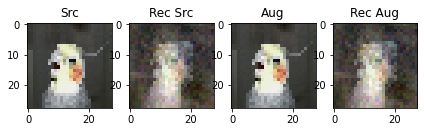

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


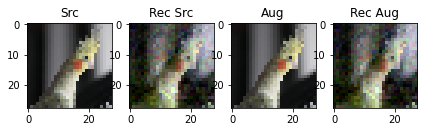

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


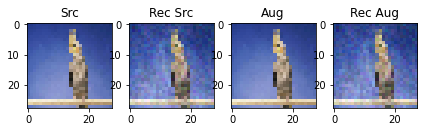

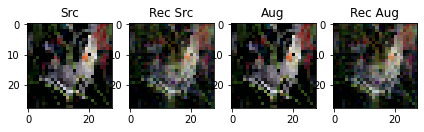

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [32]:
print_autoencoder_result(parrot_fcautoencoder_model, parrot_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='train', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

Как видно из результатов, модель достаточно неплохо обучилась восстанавливать изображения на обучающей части.

Посмотрим результат на валидационном датасете:

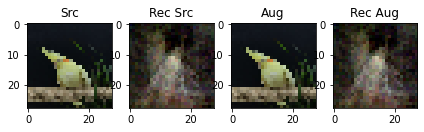

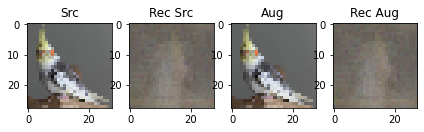

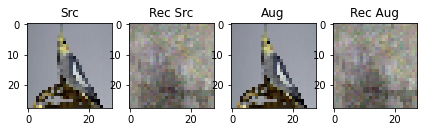

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


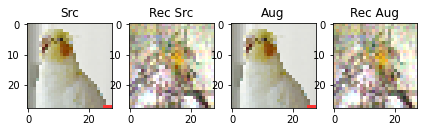

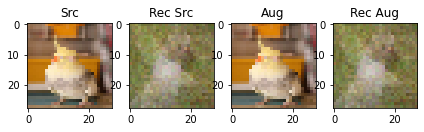

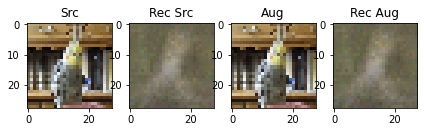

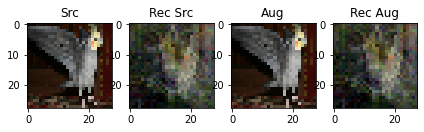

In [33]:
print_autoencoder_result(parrot_fcautoencoder_model, parrot_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

Как видно из результата, модель в отдельных случаях даже может восстановить изображение в сильно размытом варианте, сходство при этом присутствует. Но в большинстве случаев мы получаем сильно размытый шум. Это значит, что в валидацинной части есть изображения, которые крайне не похожи на изображения в обучающей части. Так как датасет маленький, то здесь вряд ли поможет даже аугментация. Требуется значительное расширение датасета.

Так как датасет очень маленький, то строить график t-SNE для него не имеет смысла.

#### 1.3.2 Шумный автоэнкодер для ParrotsDataset

Добавим преобразование CoarseDropout для трансформации изображений на обучении. Будем закрывать до 50% изображения черным кубиком. А также с вероятностью 1.0 будем добавлять шум типа ISONoise. В конфигурации модели активируем режим Noised.

In [34]:
base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

transforms_to_add = A.Compose([
    A.ISONoise(p=1.0),
    A.CoarseDropout (p=0.7, max_holes=1, max_width=int(IMAGE_SIZE*0.5), max_height=int(IMAGE_SIZE*0.5)),
])

for idx, new_transform in enumerate(transforms_to_add):
    train_transforms.add_transform(new_transform, idx+1)
    
config['model']['noised'] = True
config['datamodule']['dataset_params']['train_transforms'] = train_transforms

print("Базовые трансформации изображений датасета ParrotDataset:\n")
print(base_transforms)

print("\nТрансформации изображений датасета ParrotDataset на обучении:\n")
print(train_transforms)

Базовые трансформации изображений датасета ParrotDataset:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Трансформации изображений датасета ParrotDataset на обучении:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
  CoarseDropout(always_apply=False, p=0.7, max_holes=1, max_height=14, max_width=14, min_holes=1, min_height=14, min_width=14, fill_value=0, mask_fill_value=None),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None,

In [35]:
parrot_datamodule = ParrotDataModule.create_datamodule(**config['datamodule'])
parrot_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=10, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=10), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(parrot_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=2352, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2352, bias=True)
    )
  )
)


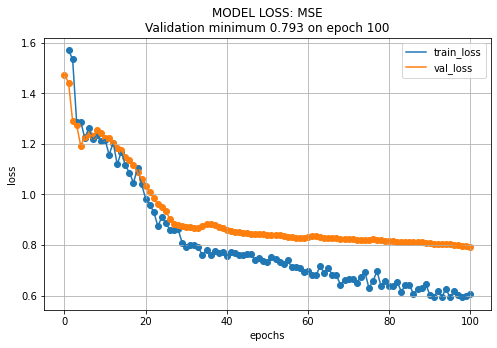

In [36]:
# Обучаем автоэнкодер
trainer.fit(parrot_fcautoencoder_model, parrot_datamodule)

In [37]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
parrot_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Мы смогли убрать переобучение у модели, но не смогли улучшить качество модели на валидации (0.758 против 0.716).

Проверим результаты на валидационной части датасета:

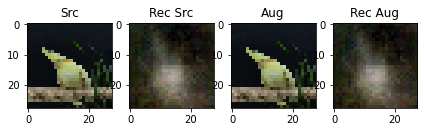

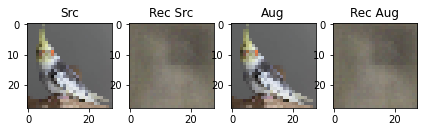

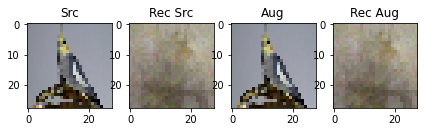

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


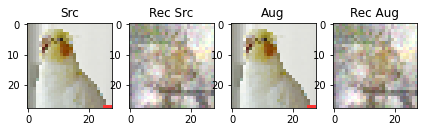

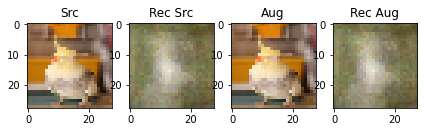

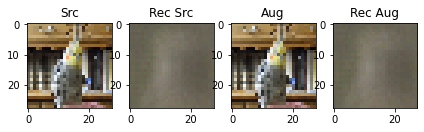

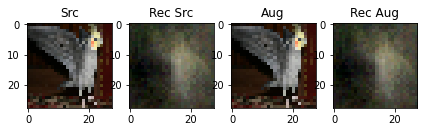

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [38]:
print_autoencoder_result(parrot_fcautoencoder_model, parrot_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

Результаты по сравнению со стандартным автокодировщиком визуально ухудшились.

### 1.4 Обучение полносвязного автоэнкодера на  данных Imagenette

Обучим стандартный автоэнкодер на датасете Imagenette. Модель аналогична модели датасета Cockatiel VS Cockatoo.

In [39]:
SEED = 24

IMAGE_SIZE = 28
IMAGE_CHANNEL_COUNT = 3

STD_NORMALIZE = [0.229, 0.224, 0.225]
MEAN_NORMALIZE = [0.485, 0.456, 0.406]

base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = None

print("Базовые трансформации изображений датасета Imagenette:\n")
print(base_transforms)

Базовые трансформации изображений датасета Imagenette:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [40]:
config = {'seed': SEED,
          'model': {
              'encoder_dims': [2048, 1024],
              'decoder_dims': [1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT],
              'latent_size': 512,
              'loss_fn': 'mse',
              'image_size': IMAGE_SIZE,
              'channel_count': IMAGE_CHANNEL_COUNT,
              'noised': False,
              'last_activation': None,
              'plot_epoch_loss': True,
              'learning_rate': 0.0001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'seed': SEED,
          },
          'datamodule': {
              'imagenette_path': r'D:\Data Science\datasets\imagenette2',
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 16,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              },
              'dataset_params': {
                  'base_transforms': base_transforms,
                  'train_transforms': train_transforms,
              },
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'resume_from_checkpoint': None,
          },
}

In [41]:
imagenette_datamodule = ImagenetteDataModule(**config['datamodule'])
imagenette_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(imagenette_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=2352, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2352, bias=True)
    )
  )
)


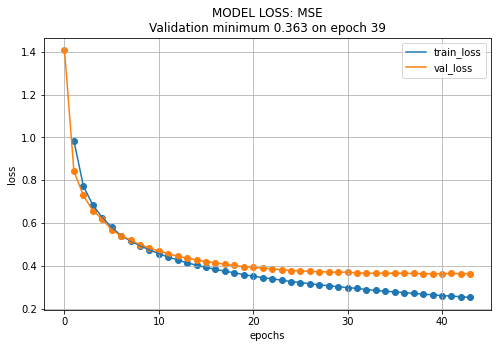

In [42]:
# Обучаем автоэнкодер
trainer.fit(imagenette_fcautoencoder_model, imagenette_datamodule)

In [43]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
imagenette_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Можем наблюдать небольшое переобучение модели. При этом на валидации модель показывает значительно лучшие результаты, чем модель с попугаями. Это можно объяснить тем, что датасет содержит большое количество разнообразных изображений.

Проверим результаты модели на валидационной части датасета:

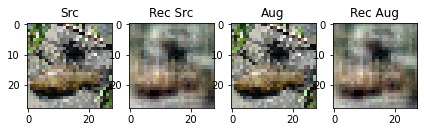

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


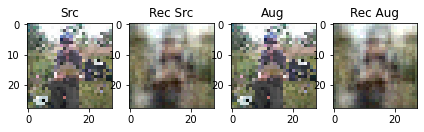

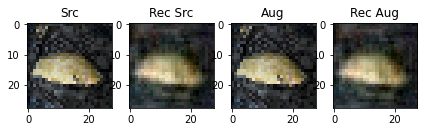

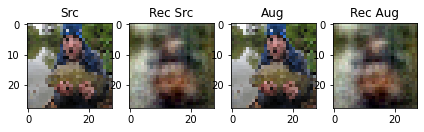

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


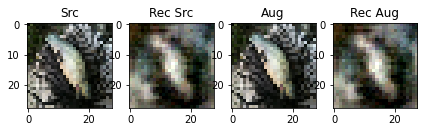

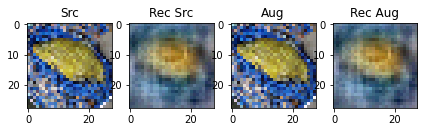

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


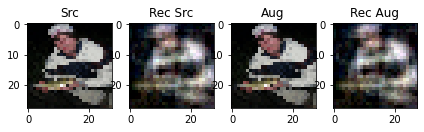

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [44]:
print_autoencoder_result(imagenette_fcautoencoder_model, imagenette_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

Как видно из результатов, модель достаточно неплохо восстанавливает изображения датасета валидации по сравнению с моделью для попугаев. Это можно связать с тем, что датасет Imagenette более разнообразен.

Посмотрим на график t-SNE:

New Shape of X:  (3924, 2)
Kullback-Leibler divergence after optimization:  2.7745273113250732
No. of iterations:  2999


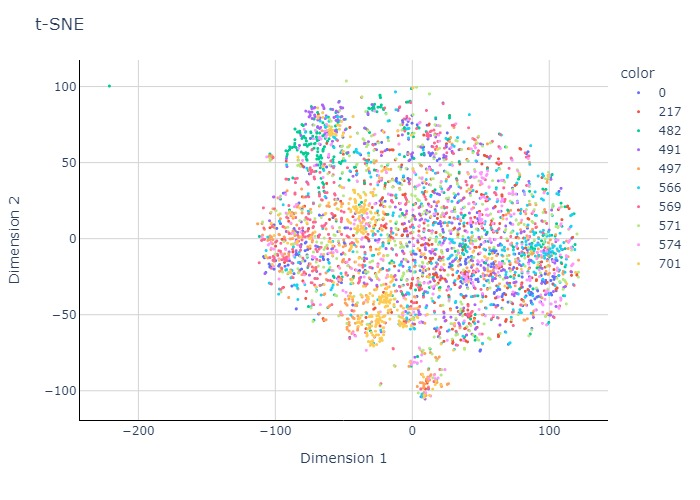

In [45]:
plot_latent_tsne(model=imagenette_fcautoencoder_model, datamodule=imagenette_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Не смотря на то, что визуально восстановленное изображение имеет большое сходство с исходным изображением, на графике t-SNE данные группируются плохо.

#### 1.4.2 Шумный автоэнкодер для Imagenete

Аналогично добавим преобразование CoarseDropout (удаление сегмента в виде прямоугольника из изображения) для трансформации изображений на обучении. Будем закрывать до 50% изображения черным кубиком. А также с вероятностью 1.0 будем добавлять шум ISONoise. В конфигурации модели активируем режим Noised.

In [46]:
base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

transforms_to_add = A.Compose([
    A.ISONoise(p=1.0),
    A.CoarseDropout (p=0.7, max_holes=1, min_width=int(IMAGE_SIZE*0.25), min_height=int(IMAGE_SIZE*0.25), 
                     max_width=int(IMAGE_SIZE*0.5), max_height=int(IMAGE_SIZE*0.5)),
])

for idx, new_transform in enumerate(transforms_to_add):
    train_transforms.add_transform(new_transform, idx+1)
    
config['model']['noised'] = True
config['datamodule']['dataset_params']['train_transforms'] = train_transforms

print("Базовые трансформации изображений датасета ParrotDataset:\n")
print(base_transforms)

print("\nТрансформации изображений датасета ParrotDataset на обучении:\n")
print(train_transforms)

Базовые трансформации изображений датасета ParrotDataset:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})

Трансформации изображений датасета ParrotDataset на обучении:

Compose([
  Resize(always_apply=False, p=1, height=28, width=28, interpolation=1),
  ISONoise(always_apply=False, p=1.0, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
  CoarseDropout(always_apply=False, p=0.7, max_holes=1, max_height=14, max_width=14, min_holes=1, min_height=7, min_width=7, fill_value=0, mask_fill_value=None),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, k

In [47]:
imagenette_datamodule = ImagenetteDataModule(**config['datamodule'])
imagenette_fcautoencoder_model = FCAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=5, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(imagenette_fcautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

FCAutoEncoder(
  (encoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=2352, out_features=2048, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2048, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=512, bias=True)
      (5): ReLU()
    )
  )
  (decoder): FCModel(
    (_fc_model): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=2048, bias=True)
      (3): ReLU()
      (4): Linear(in_features=2048, out_features=2352, bias=True)
    )
  )
)


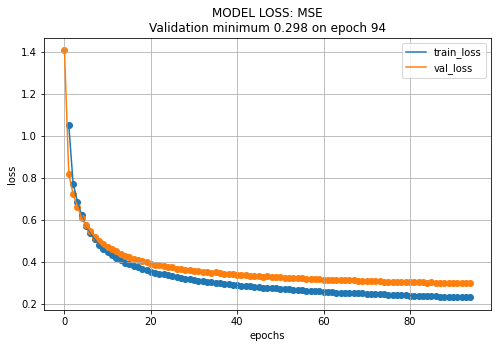

In [48]:
# Обучаем автоэнкодер
trainer.fit(imagenette_fcautoencoder_model, imagenette_datamodule)

In [49]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
imagenette_fcautoencoder_model = FCAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

После добавления шума мы смогли улучшить качество модели на валдиации с 0.363 до 2.98.

Проверим как это сказалось на результатах и на графике t-SNE:

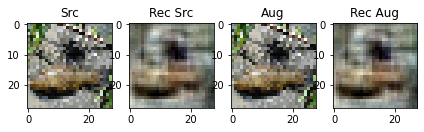

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


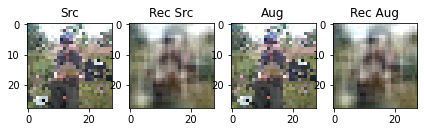

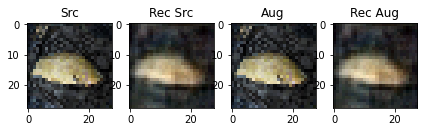

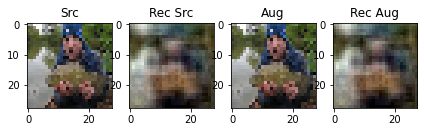

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


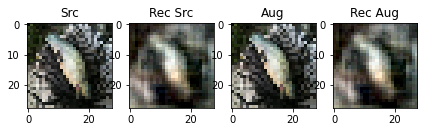

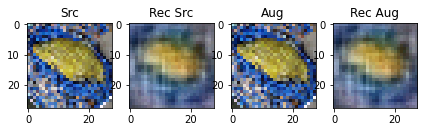

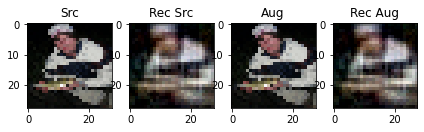

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [50]:
print_autoencoder_result(imagenette_fcautoencoder_model, imagenette_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

New Shape of X:  (3924, 2)
Kullback-Leibler divergence after optimization:  2.681853771209717
No. of iterations:  2999


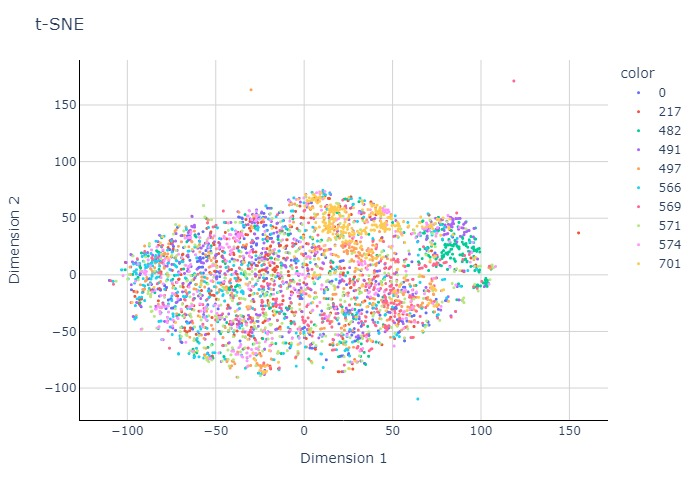

In [51]:
plot_latent_tsne(model=imagenette_fcautoencoder_model, datamodule=imagenette_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

Сильно значимых улучшений в результатаъ модели не наблюдается.

## 2 Обучение многослойного автоэнкодера на базе сверточной сети
### 2.1 Описание вспомогательных классов

Для реализации автоэнкодера на основе сверточной сети реализован класс **CNNAutoEncoder**. Который в свою очередь использует классы **CNNEncoder** и **CNNDecoder**.

CNNAutoEncoder рассчитан на входное изображение размером Cx48x48, где С - число каналов. Число каналов можно задать при инициализации класса.

Архитектура сверточных слоев энкодера и декодера вдохновлялась архитектурой VGG16. На выходе CNNEncoder использует два полносвязных слоя. Последний полносвязный слой является латентным и его размер является гиперпараметром. CNNDecoder является симметричным энкодеру.

Пример инициализации автоэнкодера:

> model = CNNAutoEncoder(latent_size=512, channel_count=3, loss_fn='mse', noised=True, learning_rate=0.001, l2_regularization=0.01, adam_betas=(0.99, 0.999), plot_epoch_loss=True, seed=2022)

Для расчета параметров выхода сверточных слоев были реализованы функции-калькуляторы:

In [52]:
# Пример расчета выхода сверточного слоя
calc_conv2d_output_size(image_size=(48, 48), kernel_size=(3, 3), padding=0, stride=1)

(46.0, 46.0)

In [53]:
# Пример расчета выхода транспонированного сверточного слоя
calc_transpose_conv2d_output_size(image_size=(3, 3), kernel_size=(3, 3), padding=0, padding_out=0, stride=2)

(7, 7)

### 2.2 Обучение стандартного сверточного автоэнкодера

#### 2.2.1 Обучение стандартного сверточного автоэнкодера на данных ParrotDataset

In [54]:
SEED = 24

IMAGE_SIZE = 48
IMAGE_CHANNEL_COUNT = 3

STD_NORMALIZE = [0.229, 0.224, 0.225]
MEAN_NORMALIZE = [0.485, 0.456, 0.406]

base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = None

print("Базовые трансформации изображений датасета ParrotDataset:\n")
print(base_transforms)

Базовые трансформации изображений датасета ParrotDataset:

Compose([
  Resize(always_apply=False, p=1, height=48, width=48, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [55]:
config = {'seed': SEED,
          'model': {
              'latent_size': 1024,
              'loss_fn': 'mse',
              'channel_count': IMAGE_CHANNEL_COUNT,
              'noised': False,
              'plot_epoch_loss': True,
              'learning_rate': 0.001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'seed': SEED,
          },
          'datamodule': {
              'parrot_xlsx': 'dataset.xlsx',
              'photo_dir': 'parrots_images',
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 16,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              },
              'dataset_params': {
                  'base_transforms': base_transforms,
                  'train_transforms': train_transforms,
              },
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'resume_from_checkpoint': None,
          },
}

In [56]:
parrot_datamodule = ParrotDataModule.create_datamodule(**config['datamodule'])
parrot_cnnautoencoder_model = CNNAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='train_loss', mode='min'),
        TQDMProgressBar(refresh_rate=10), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(parrot_cnnautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

CNNAutoEncoder(
  (encoder): CNNEncoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU()
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (17): ReLU()
      (18): Conv2d(256, 256,

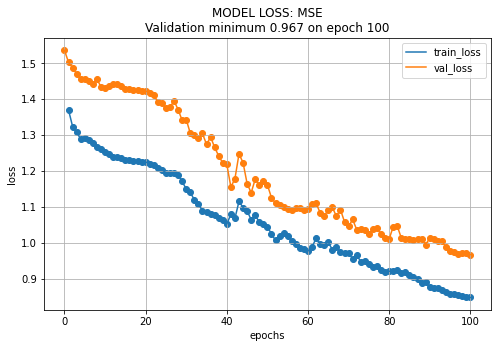

In [57]:
# Обучаем автоэнкодер
trainer.fit(parrot_cnnautoencoder_model, parrot_datamodule)

In [58]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[0]
parrot_cnnautoencoder_model = CNNAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Исходя из графика обучения ошибка на валидации у нас стала хуже, по сравнению с моделью на основе полносвязных слоев (0.948 против 0.716).

Проверим результаты модели на валидационной части датасета:

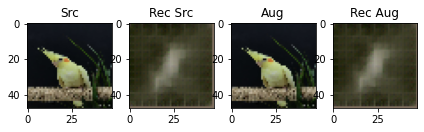

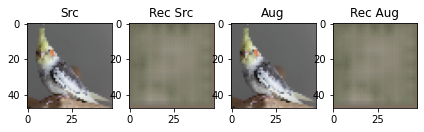

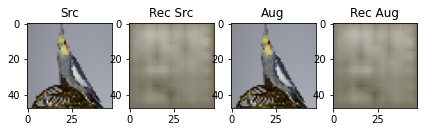

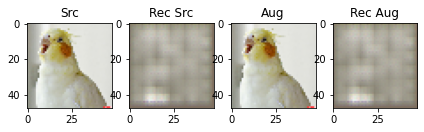

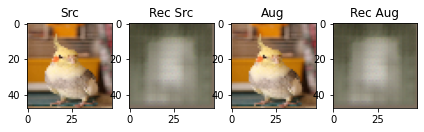

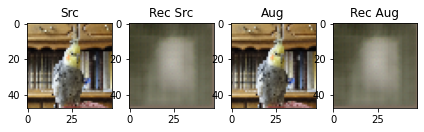

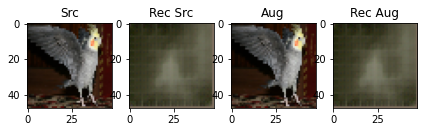

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [59]:
print_autoencoder_result(parrot_cnnautoencoder_model, parrot_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

#### 2.2.2 Обучение стандартного сверточного автоэнкодера  на данных Imagenette

In [60]:
SEED = 24

IMAGE_SIZE = 48
IMAGE_CHANNEL_COUNT = 3

STD_NORMALIZE = [0.229, 0.224, 0.225]
MEAN_NORMALIZE = [0.485, 0.456, 0.406]

base_transforms = BaseImageTransform(height=IMAGE_SIZE, width=IMAGE_SIZE, std=STD_NORMALIZE, mean=MEAN_NORMALIZE)
train_transforms = None

print("Базовые трансформации изображений датасета Imagenette:\n")
print(base_transforms)

Базовые трансформации изображений датасета Imagenette:

Compose([
  Resize(always_apply=False, p=1, height=48, width=48, interpolation=1),
  Normalize(always_apply=False, p=1.0, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0),
  ToTensorV2(always_apply=True, p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={})


In [61]:
config = {'seed': SEED,
          'model': {
              'latent_size': 512,
              'loss_fn': 'mse',
              'channel_count': IMAGE_CHANNEL_COUNT,
              'noised': False,
              'plot_epoch_loss': True,
              'learning_rate': 0.001, 
              'l2_regularization': 0.01,
              'adam_betas': (0.99, 0.999),
              'seed': SEED,
          },
          'datamodule': {
              'imagenette_path': r'D:\Data Science\datasets\imagenette2',
              'seed': SEED,
              'train_loader_params': {
                    'batch_size': 16,
                    'shuffle': True,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': True,
              },
              'val_loader_params': {
                    'batch_size': 16,
                    'shuffle': False,
                    'num_workers': 0,
                    'pin_memory': False,
                    'drop_last': False
              },
              'dataset_params': {
                  'base_transforms': base_transforms,
                  'train_transforms': train_transforms,
              },
          },
         'trainer': {
              'max_epochs': 100,
              'gpus': 1 if torch.cuda.is_available() else 0,
              'resume_from_checkpoint': None,
          },
}

In [62]:
imagenette_datamodule = ImagenetteDataModule(**config['datamodule'])
imagenette_cnnautoencoder_model = CNNAutoEncoder(**config['model'])

checkpoint_dir = 'checkpoint/'
if os.path.exists(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

callbacks = [
        EarlyStopping('val_loss', min_delta=0.001, patience=3, mode='min'),
        ModelCheckpoint(dirpath=checkpoint_dir, monitor='val_loss', mode='min'),
        TQDMProgressBar(refresh_rate=100), 
]

trainer = pl.Trainer(**config['trainer'], callbacks=callbacks)

print('Структура автоэнкодера:\n')
print(imagenette_cnnautoencoder_model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Структура автоэнкодера:

CNNAutoEncoder(
  (encoder): CNNEncoder(
    (encoder_cnn): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU()
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU()
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU()
      (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (17): ReLU()
      (18): Conv2d(256, 256,

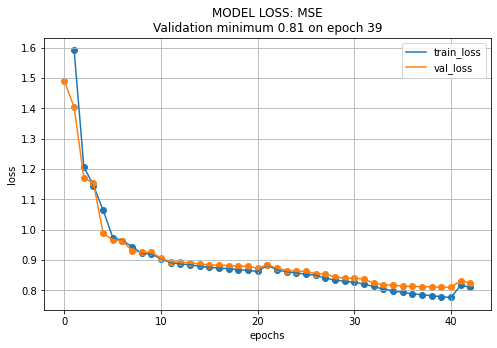

In [63]:
# Обучаем автоэнкодер
trainer.fit(imagenette_cnnautoencoder_model, imagenette_datamodule)

In [64]:
# Откатим модель к чекпоинту с лучшим результатом на валидации
checkpoint = callbacks[1]
imagenette_cnnautoencoder_model = CNNAutoEncoder.load_from_checkpoint(checkpoint.best_model_path, **config['model'])

Качесто обучения по сравнению с автоэнкодером на основе полносвязной сети ухудшилось примерно в 3 раза.

Проверим результаты на валидационной части датасета:

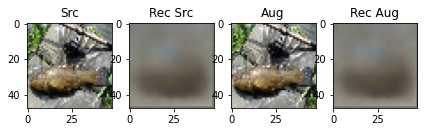

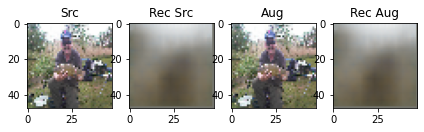

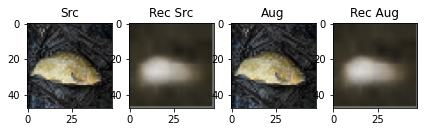

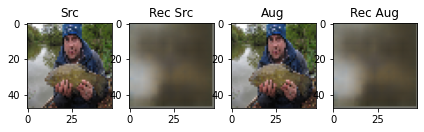

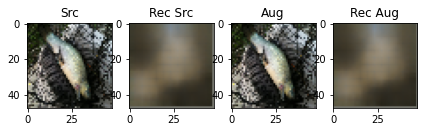

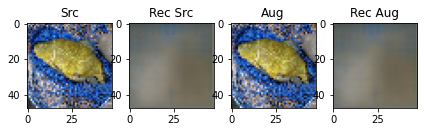

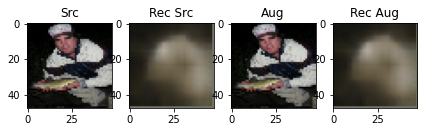

C:\ProgramData\Anaconda3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.



In [65]:
print_autoencoder_result(imagenette_cnnautoencoder_model, imagenette_datamodule, image_size=IMAGE_SIZE, 
                         channels_count=IMAGE_CHANNEL_COUNT, split='val', denormalize=True, 
                         std=STD_NORMALIZE, mean=MEAN_NORMALIZE)

New Shape of X:  (3924, 2)
Kullback-Leibler divergence after optimization:  2.0532913208007812
No. of iterations:  2999


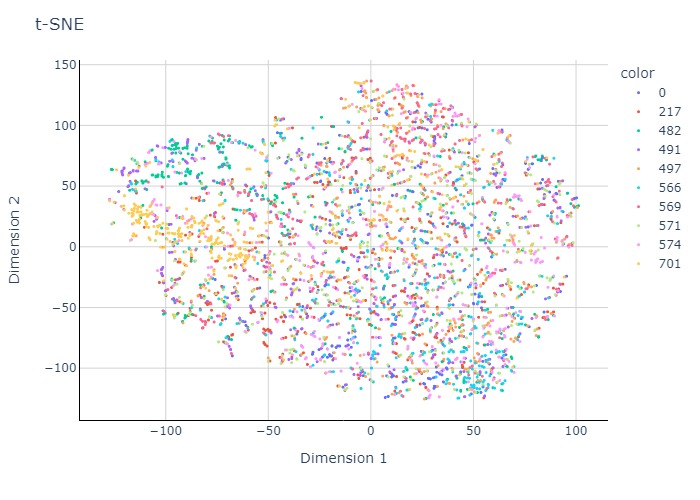

In [66]:
plot_latent_tsne(model=imagenette_cnnautoencoder_model, datamodule=imagenette_datamodule, perplexity=10, learning_rate=200, 
                 n_iter=3000, n_jobs=-1, verbose=0)

# ИТОГИ

В данной работе проведено исследование качества различных типов автоэнкодеров на датасетах MNIST, Imagenette и ParrotDataset.
Ожидалось, что автоэнкодер на основе сверточных сетей будет выдавать более лучший результат, чем автоэнкодер на основе полносвязных слоев. Но в итоге автоэнкодер на основе полносвязных слоев выдал более лучшие результаты. Предположительно это связано с необходимостью использовать более современные архитектуры сверточных сетей.

Ниже приведена сводная таблица  результатов всех экспериментов.

| Датасет  | Модель  | Гиперпараметры  | Аугментация  | Визуальная оценка | t-SNE   | RMSE |
| -------- |:-------:|:---------------:|:------------:|:-----------------:|:-------:| --------:|
| MNIST| FCAutoEncoder | latent_size=2, encoder_dims=[128], decoder_dims=[128, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | Нет | Восстановление плохое | Группировки нет | 0.05 |
| MNIST| FCAutoEncoder | latent_size=32, encoder_dims=[128], decoder_dims=[128, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | Нет | Восстановление хорошее | Есть группировка с отдельными пересечениями | 0.017 |
| MNIST| FCAutoEncoder | latent_size=128, encoder_dims=[256], decoder_dims=[256, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | Нет | Восстановление хорошее | Есть группировка с отдельными пересечениями | 0.010 |
| MNIST| FCAutoEncoder | latent_size=128, encoder_dims=[256], decoder_dims=[256, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | CoarseDropout | Восстановление хорошее | Есть группировка с отдельными пересечениями | 0.010 |
| ParrotsDataset| FCAutoEncoder | latent_size=512, encoder_dims=[2048, 1024], decoder_dims=[1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | Нет | На датасете обучения восстановление неплохое, на датасете  валидации восстановление слишком шумное и мыльное| Не делалось | 0.716 |
| ParrotsDataset| FCAutoEncoder | latent_size=512, encoder_dims=[2048, 1024], decoder_dims=[1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | CoarseDropout, ISONoise | И на обучающей части, и на валидационной восстановление плохое| Не делалось | 0.793 |
| Imagenette | FCAutoEncoder | latent_size=512, encoder_dims=[2048, 1024], decoder_dims=[1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | Нет | Визуально изображение похоже на оригинал, но достаточно размыто | Группировки нет | 0.363 |
| Imagenette | FCAutoEncoder | latent_size=512, encoder_dims=[2048, 1024], decoder_dims=[1024, 2048, IMAGE_SIZE*IMAGE_SIZE*IMAGE_CHANNEL_COUNT] | CoarseDropout, ISONoise | Визуально изображение похоже на оригинал, но достаточно размыто | Группировки нет | 0.298 |
| ParrotsDataset| CNNAutoEncoder | latent_size=1024 | Нет | Восстановление плохое, качество ухудшилось по сравнению с FCAutoEncoder | Не делалось | 0.967 |
| Imagenette | CNNAutoEncoder | latent_size=512 | Нет | Восстановление плохое, качество ухудшилось по сравнению с FCAutoEncoder | Группировки нет | 0.810 |

**Что можно улучшить для получения более лучших результатов:**

- попробовать поэкспериментировать со слоями Dropout и BatchNorm
- попробовать использовать более современные архитектуры сверточных сетей